In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [2]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [3]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [6]:
pred = {}
n_splits = 10
case = 2
a = 2
b = 3
num_seed = 10
cost = 'abs'

for method in ['normal', 'transfer']:
    pred[method] = {}
    for cost in ['abs', 'rel']:
        pred[method][cost] = {}
        for iterations in [2000, 10000]:
            pred[method][cost][iterations] = {}
            for random_seed in range(num_seed):
                pred[method][cost][iterations][random_seed] = {}
                for appliance in APPLIANCES_ORDER:
                    pred[method][cost][iterations][random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
                
kf = KFold(n_splits = n_splits)
for method in ['normal', 'transfer']:
    print "method: ", method
    
    for cost in ['abs', 'rel']:
        print "cost: ", cost

        for iterations in [2000, 10000]:
            print "iterations: ", iterations

            for random_seed in range(10):
                print "random seed: ", random_seed

                for train_percentage in range(10, 110, 10):
                    print "training percentage: ", train_percentage
                    rd = 0

                    for train_max, test in kf.split(sd_df):
                        print "round: ", rd
                        rd += 1

                        num_train = int((train_percentage*len(train_max)/100)+0.5)
                        num_test = len(test)

                        # get the random training data from train_max based on then random seed
                        if train_percentage==100:
                            train = train_max
                        else:
                            train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                        # get the index of training and testing data
                        train_ix = sd_df.index[train]
                        test_ix = sd_df.index[test]
#                         print "test_ix: ", test_ix

                        # create the tensor
                        train_test_ix = np.concatenate([test_ix, train_ix])
                        df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                        tensor = get_tensor(df_t, dfc_t)
                        tensor_copy = tensor.copy()
                        # set the appliance consumption to be missing for testing data
                        tensor_copy[:num_test, 1:, :] = np.NaN
                        
                        if method == "transfer":
                            # transfer learning
                            H_a, A_a, T_a = learn_HAT(case, au_tensor, a, b, num_iter=iterations, lr=0.1, dis=False, 
                                                      cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
                            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=iterations, lr=0.1, dis=False, 
                                                cost_function=cost, A_known = A_a, T_known=np.ones(12).reshape(-1, 1))
                        else:
                            # normal learning
                            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=iterations, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))

                        # get the prediction
                        HAT = multiply_case(H, A, T, case)
                        for appliance in APPLIANCES_ORDER:
                            pred[method][cost][iterations][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

method:  normal
cost:  abs
iterations:  2000
random seed:  0
training percentage:  10
round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
training percentage:  20
round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
training percentage:  30
round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
training percentage:  40
round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
training percentage:  50
round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
training percentage:  60
round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
training percentage:  70
round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
training percentage:  80
round:  0
round:  1
round:  2
round:  3

KeyboardInterrupt: 

In [28]:
out = {}
for random_seed in range(10):
    out[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [29]:
out_transfer = {}
for random_seed in range(10):
    out_transfer[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [ ]:
mean_out_transfer = mean_out_transfer.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})
mean_out = mean_out.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})

In [40]:
mean_out_2k = mean_out.rename(columns={'dw_normal':'dw_normal_2k', 'fridge_normal':'fridge_normal_2k', 'hvac_normal':'hvac_normal_2k',
                                             'mw_normal':'mw_normal_2k', 'oven_normal':"oven_normal_2k", 'wm_normal':'wm_normal_2k'})
mean_out_transfer_2k = mean_out_transfer.rename(columns={'dw_transfer':'dw_transfer_2k', 'fridge_transfer':'fridge_transfer_2k', 'hvac_transfer':'hvac_transfer_2k',
                                             'mw_transfer':'mw_transfer_2k', 'oven_transfer':"oven_transfer_2k", 'wm_transfer':'wm_transfer_2k'})

all_out_2k = pd.concat([mean_out_2k, mean_out_transfer_2k], axis=1)

In [38]:
mean_out_10k = mean_out.rename(columns={'dw_normal':'dw_normal_10k', 'fridge_normal':'fridge_normal_10k', 'hvac_normal':'hvac_normal_10k',
                                             'mw_normal':'mw_normal_10k', 'oven_normal':"oven_normal_10k", 'wm_normal':'wm_normal_10k'})
mean_out_transfer_10k = mean_out_transfer.rename(columns={'dw_transfer':'dw_transfer_10k', 'fridge_transfer':'fridge_transfer_10k', 'hvac_transfer':'hvac_transfer_10k',
                                             'mw_transfer':'mw_transfer_10k', 'oven_transfer':"oven_transfer_10k", 'wm_transfer':'wm_transfer_10k'})

all_out_10k = pd.concat([mean_out_10k, mean_out_transfer_10k], axis=1)

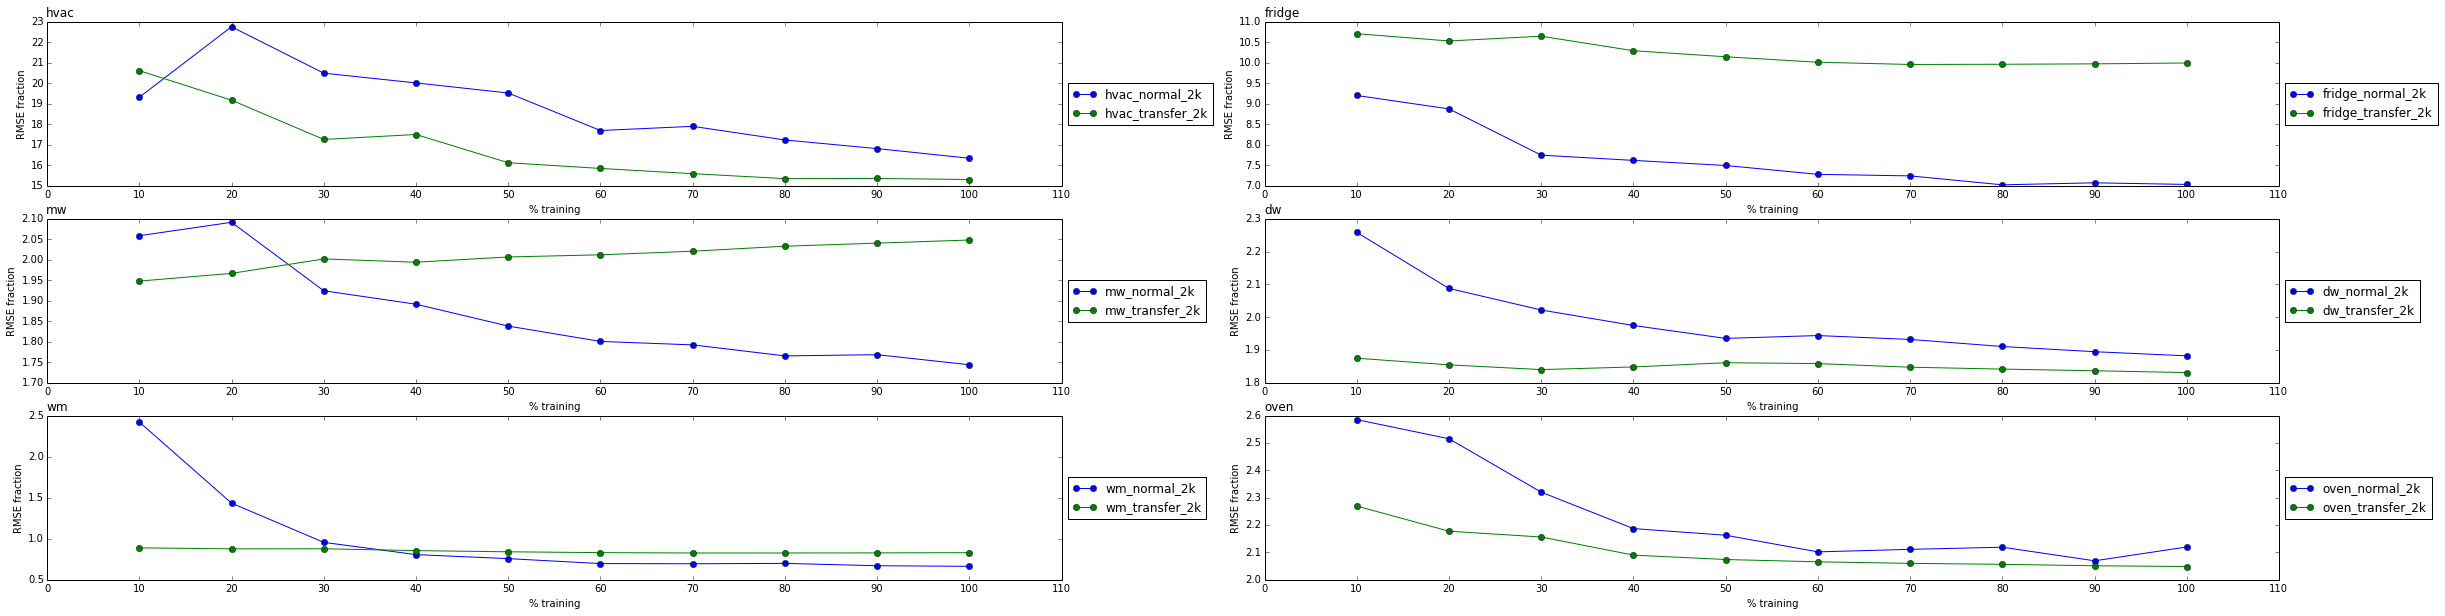

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(50, 100))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out_10k[appliance + '_normal_10k']
    df2 = all_out_10k[appliance + '_transfer_10k']
    df3 = all_out_2k[appliance + '_normal_2k']
    df4 = all_out_2k[appliance + '_transfer_2k']
#     df4 = all_out[appliance+ '_transfer_reg']

#     df = pd.concat([df3, df4], axis=1)
    df = pd.concat([df1, df2, df3, df4], axis=1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(40, 10), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/0711/prediction_normal_transfer_10k_2k", bbox_inches="tight", dpi=300, format="pdf")

In [7]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)
    
pred = load_obj("pred")

{'normal': {'abs': {2: {0: {'aggregate': {10: [            0         1         2         3         4         5         6   \
       54    1.183657  0.884888  0.930664  1.303270  1.428456  1.746085  0.930719   
       203   0.940836  0.706448  0.741925  1.041440  1.129941  1.389066  0.740765   
       527   1.056147  0.788342  0.829545  1.160690  1.276738  1.557521  0.830071   
       1450  1.476898  1.099580  1.158027  1.618036  1.790372  2.176931  1.159862   
       
                   7         8         9         10        11  
       54    0.995809  1.034401  1.257163  1.157749  1.364713  
       203   0.794929  0.826546  1.002259  0.918615  1.083024  
       527   0.887190  0.921252  1.120551  1.033672  1.218380  
       1450  1.237520  1.284290  1.564221  1.446956  1.705338  ,
                   0         1         2         3         4         5         6   \
       1524  1.186851  0.886407  0.933382  1.306224  1.434100  1.749959  0.934211   
       1731  0.960750  0.720545  0.7

### -------------------------------------------------------------------------------------------------------------------------------
### Regularization exploration

## Normal learning with regularization term

In [64]:
import autograd.numpy as np
from numpy import linalg as LA
from autograd import multigrad

def cost_abs_reg(H, A, T, E_np_masked, case):
    la = 10
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error = (HAT - E_np_masked)[mask].flatten() + la * LA.norm(~np.isnan(H)) + la * LA.norm(~np.isnan(A)) + la * LA.norm(~np.isnan(T))
    return np.sqrt((error ** 2).mean())

def learn_HAT_reg(case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
              A_known=None, T_known=None, random_seed=0, random_mul_constant=1,
              random_add_constant=0):
    np.random.seed(random_seed)
    if cost_function == 'abs':
        cost = cost_abs_reg
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)*random_mul_constant+random_add_constant

    A = np.random.rand(*A_dim)*random_mul_constant+random_add_constant
    T = np.random.rand(*T_dim)*random_mul_constant+random_add_constant

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T